In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


creating dataframe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/completeData.csv').astype({'valence_tags': np.float32, 'arousal_tags':np.float32, 'dominance_tags':np.float32})

In [ ]:
from ast import literal_eval
for x in range(len(df['seeds'])):
  df['seeds'][x] = literal_eval(df['seeds'][x])

<ipython-input-4-8b33d4aafe1d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seeds'][x] = literal_eval(df['seeds'][x])


finding number of uniue seeds

In [ ]:
uniqueSeeds = []
for y in df['seeds']:
  for x in y:
    if x not in uniqueSeeds:
      uniqueSeeds.append(x)
uniqueSeeds.sort()
print(len(uniqueSeeds))

272


dropping unnecessary columns

In [ ]:
df2 = df.drop(columns=['lastfm_url', 'track', 'artist','mbid','spotify_id','genre','type','id','uri','track_href','analysis_url'])
df2 = df2.astype({'valence_tags': np.float64, 'arousal_tags':np.float64, 'dominance_tags':np.float64, 'danceability':np.float64, 'energy':np.float64, 'speechiness':np.float64, 'acousticness':np.float64, 'instrumentalness':np.float64, 'liveness':np.float64})

creating mood variable + replace seeds w/mood column in dataframe

In [ ]:
mood = 'calm'

IF THE MOOD IS PRESENT IN THE SONG, THEN 1.
IF THE SONG DOES NOT ELICIT THE MOOD, THEN 0.

In [ ]:
moods = []
for i in range(len(df2)):
  if(mood in df2['seeds'][i]):
    moods.append(1)
  else:
    moods.append(0)
df2['mood'] = moods
df2 = df2.drop(columns=['seeds'])

separate data into X and y - X is a dataframe w equal number of songs w/the mood and songs w/out the mood, y = the mood columns (0s and 1s)

In [ ]:
sampleNum=(df2['mood'].value_counts()[1])
X = pd.concat([df2[df2.mood == 0].sample(sampleNum), df2[df2.mood == 1].sample(sampleNum)])
y = X['mood']
X = X.drop(columns=['mood','Unnamed: 0','number_of_emotion_tags', 'valence_tags', 'arousal_tags', 'dominance_tags'])

creating x/y train/test data

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

create KNN classifier fit to Xtrain, YTrain

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)

KNeighborsClassifier()

checking precision and accuracy, but ultimately precision will be compared

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

precisions = []

# Calculating f1 score for K values between 1 and 40
for i in range(1, 300):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    precisions.append(precision_score(y_test, pred_i))

Text(0, 0.5, 'Precision Score')

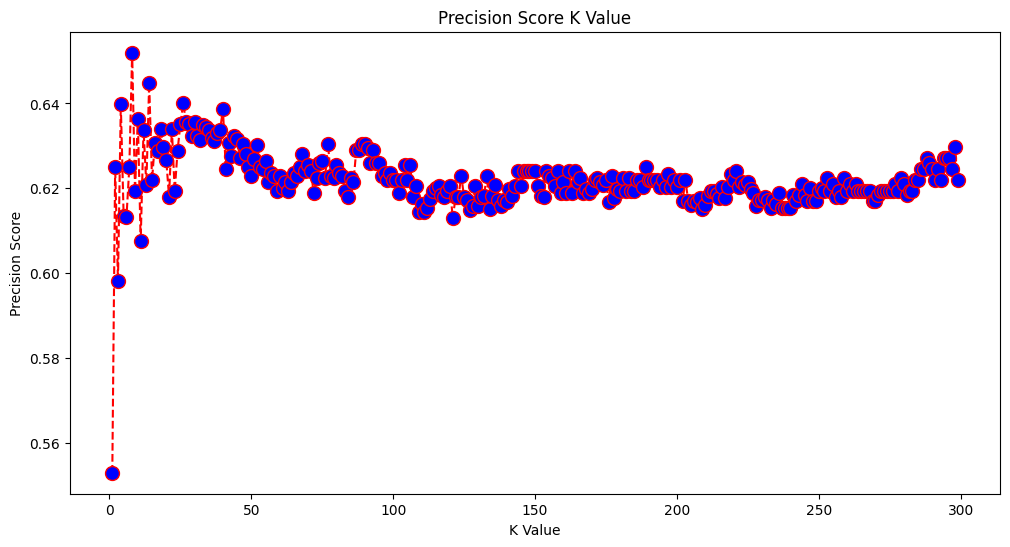

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 300), precisions, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Precision Score K Value')
plt.xlabel('K Value')
plt.ylabel('Precision Score')

Text(0, 0.5, 'Accuracy Score')

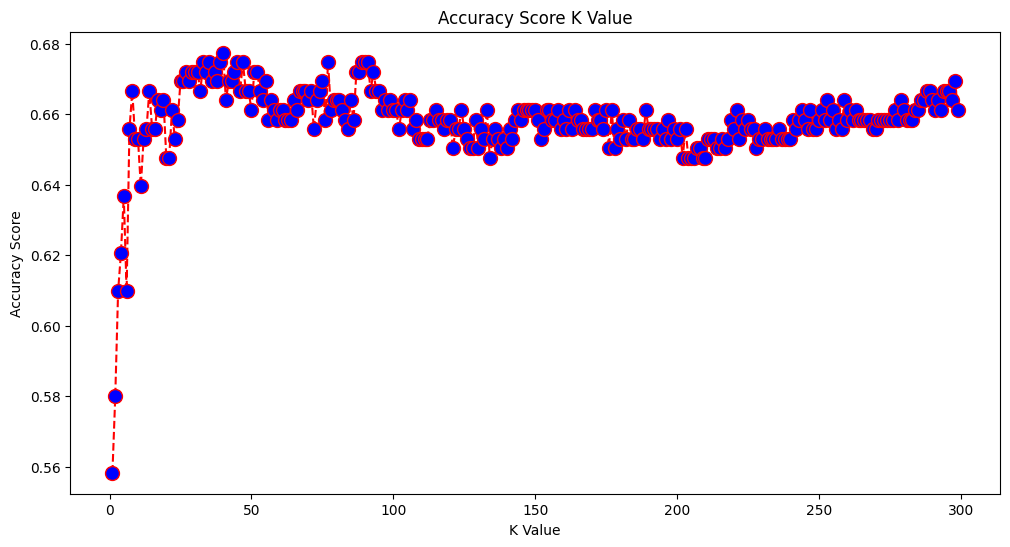

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

accuracies = []

# Calculating f1 score for K values between 1 and 40
for i in range(1, 300):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    # using average='weighted' to calculate a weighted average for the 4 classes
    accuracies.append(accuracy_score(y_test, pred_i))

plt.figure(figsize=(12, 6))
plt.plot(range(1, 300), accuracies, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Accuracy Score K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy Score')

In [ ]:
maxAccuracy = 0
maxInd2 = 0
for x in range(len(accuracies)):
  if(accuracies[x]>maxAccuracy):
    maxAccuracy = accuracies[x]
    maxInd2 = x+1
print("max accuracies", maxAccuracy, maxInd2)

maxPrecision = 0
maxInd = 0
for x in range(len(precisions)):
  if(precisions[x]>maxPrecision):
    maxPrecision = precisions[x]
    maxInd = x+1
print("max precisions", maxPrecision, maxInd)
print(accuracies[maxInd])

max accuracies 0.6775067750677507 40
max precisions 0.6519607843137255 8
0.6531165311653117


create a classifier for the "k" that had the best precision

In [ ]:
from sklearn.metrics import classification_report

classifierBest = KNeighborsClassifier(n_neighbors=maxInd)
classifierBest.fit(X_train, y_train)
y_predBest = classifierBest.predict(X_test)
print(classification_report(y_test, y_predBest))

              precision    recall  f1-score   support

           0       0.68      0.61      0.65       184
           1       0.65      0.72      0.68       185

    accuracy                           0.67       369
   macro avg       0.67      0.67      0.67       369
weighted avg       0.67      0.67      0.67       369



accuracies and precision:

In [ ]:
print(confusion_matrix(y_test, y_predBest))
print("accuracy: ", 100*accuracy_score(y_test,y_predBest))
print("precision: ", 100*precision_score(y_test,y_predBest))

[[113  71]
 [ 52 133]]
accuracy:  66.66666666666666
precision:  65.19607843137256


              precision    recall  f1-score   support

           0       0.68      0.61      0.65       184
           1       0.65      0.72      0.68       185

    accuracy                           0.67       369
   macro avg       0.67      0.67      0.67       369
weighted avg       0.67      0.67      0.67       369



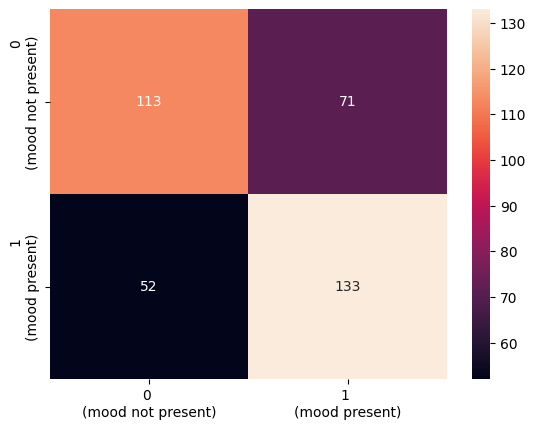

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Adding classes names for better interpretation
classes_names = ['0 \n(mood not present)','1 \n(mood present)']
cm = pd.DataFrame(confusion_matrix(y_test, y_predBest),
                  columns=classes_names, index = classes_names)

# Seaborn's heatmap to better visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d');

print(classification_report(y_test, y_predBest))

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,classifierBest.predict_proba(X_test)[:, 1])

0.6861045828437132

In [ ]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 25.1 MB/s eta 0:00:00


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import SpotifyException


cid = 'REDACTED'
secret = 'REDACTED'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
def returnSample(track):
  audioFeatures=sp.audio_features(track)[0]
  audioFeatures.pop("type")
  audioFeatures.pop("id")
  audioFeatures.pop("uri")
  audioFeatures.pop("track_href")
  audioFeatures.pop("analysis_url")

  sampleDf = pd.DataFrame(audioFeatures,index=[0])
  return scaler.transform(sampleDf)

In [ ]:
def get_playlist_tracks_features(playlistId):
    # Ref - https://stackoverflow.com/questions/39086287/spotipy-how-to-read-more-than-100-tracks-from-a-playlist?noredirect=1&lq=1
    results = sp.user_playlist_tracks(playlist_id=playlistId)
    playlist_items = results['items']
    uris = []
    artists = []
    songs = []

    while results['next']:
        results = sp.next(results)
        playlist_items.extend(results['items'])

    for item in playlist_items:
        tracksArtists=[]
        for artist in item["track"]["artists"]:
          tracksArtists.append(artist["name"])
        artists.append(tracksArtists)
        uris.append(item["track"]["uri"])
        songs.append(item["track"]["name"])
    return {"uris" : uris, "artists" : artists, "songs" : songs}

In [ ]:
def returnPlayListTracksSamples(features):
  uris = features["uris"]
  samples = []
  for uri in uris:
    if len(samples)==0:
      samples = returnSample(uri)
    else:
      samples=np.concatenate((returnSample(uri),samples),axis=0)
  return samples

In [ ]:
features = get_playlist_tracks_features("spotify:playlist:37i9dQZF1DWTC99MCpbjP8")
#https://open.spotify.com/playlist/37i9dQZF1DWTC99MCpbjP8
samples=returnPlayListTracksSamples(features)

In [ ]:
predictions=classifierBest.predict(samples)

In [ ]:
samplesDf = pd.DataFrame(features)
samplesDf=samplesDf.drop(columns=["uris"])
samplesDf['Mood'] = predictions

In [ ]:
samplesDf.rename(columns={"artists":"Artists","songs":"Songs"}).to_csv("CalmPlaylistResults")

In [ ]:
samples2=returnPlayListTracksSamples("spotify:playlist:6IUbTctWaX4NhoxpE7frqi")